In [5]:
import os
import torch
import argparse
import warnings
import random
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from anndata import AnnData
from VGAE.src.graph_func import graph_construction
from VGAE.src.utils_func import mk_dir, adata_preprocess, load_visium_sge
from VGAE.src.SEDR_train import SEDR_Train


The processed data is a matrix for each cell, with the corresponding pca_n_comps principal components

We analyze the [dataset](https://github.com/spacetx-spacejam/data) used by [Tangram](https://www.nature.com/articles/s41592-021-01264-7#data-availability).

### Helper Functions

In [6]:
def load_adata(data_name, n_clusters=20, pca_n_comps=200):
    data_root = './data/10x_Genomics_Visium/'
    # data_name = 'Visium_FFPE_Mouse_Brain'
    save_fold = os.path.join('./output/10x_Genomics_Visium/', data_name)
    # ################## Load data
    adata_h5 = load_visium_sge(sample_id=data_name, save_path=data_root)
    adata_h5.var_names_make_unique()
    adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=pca_n_comps)
    return adata_h5, adata_X

### Read the CSV and format the data

In [7]:
datapath = "data/"
cell_gene_matrix = pd.read_csv(datapath + 'cell-gene-matrix.csv')
spatial_data = pd.read_csv(datapath + 'Allen_MERFISH_spots_with_anatomy.csv')
genes = pd.read_csv(datapath + 'MERFISH_genes.csv')


In [8]:
cell_gene_matrix.to_numpy()
# spatial_data.head()
# genes.head()
# spatial_data.shape

array([[0, 0, 0, ..., 67, 1161.11337076, 6178.3830543],
       [1, 1, 0, ..., 233, 1162.91337076, 6113.1330543],
       [2, 2, 0, ..., 97, 1168.31337076, 6046.0830543],
       ...,
       [2396, 2396, 0, ..., 99, 3165.41337076, 5190.1830543],
       [2397, 2397, 1, ..., 96, 3189.71337076, 5292.7830543],
       [2398, 2398, 0, ..., 66, 3196.91337076, 5196.9330543]],
      dtype=object)

In [9]:
def plot_spatial(spatial_data, data_name):
    fig, ax = plt.subplots(nrows=1, ncols=1)

    # get the spatial information
    spatial_x = spatial_data['x_um']
    spatial_y = spatial_data['y_um']


    ax.scatter(spatial_x, spatial_y, s=1)
    ax.set_xlim(min(spatial_x), max(spatial_x))
    ax.set_ylim(min(spatial_y), max(spatial_y))
    plt.title(data_name)
    plt.show()
    
def plot_cell2gene(cell_gene_matrix, data_name):
    # cell_to_gene_matrix = sc.pp.normalize_total(cell_gene_matrix, target_sum=1, exclude_highly_expressed=True, inplace=False)['X']
    plt.figure(figsize=(8,80), dpi=100)
    plt.spy(cell_gene_matrix, markersize=0.01)
    plt.title(data_name)
    plt.show()

               0     1     2     3     4     5     6     7     8     9     \
Unnamed: 0        0     1     2     3     4     5     6     7     8     9   
1700022I11Rik     0     0     0     0     0     0     0     0     0     0   
1810046K07Rik     0     0     0     0     0     0     0     1     0     0   
5031425F14Rik     0     1     0     0     0     0     0     0     0     0   
5730522E02Rik     0     1     1     0     1     2     4     2     2     0   

               ...  2389  2390  2391  2392  2393  2394  2395  2396  2397  2398  
Unnamed: 0     ...  2389  2390  2391  2392  2393  2394  2395  2396  2397  2398  
1700022I11Rik  ...     0     0     0     0     1     0     0     0     1     0  
1810046K07Rik  ...     0     1     1     0     0     0     0     1     0     0  
5031425F14Rik  ...     0     0     0     0     1     0     0     0     0     0  
5730522E02Rik  ...     3     0     1     1     0     0     0     1     0     0  

[5 rows x 2399 columns]
dataset:  MERFISH
size: (2

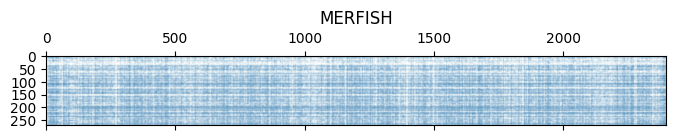

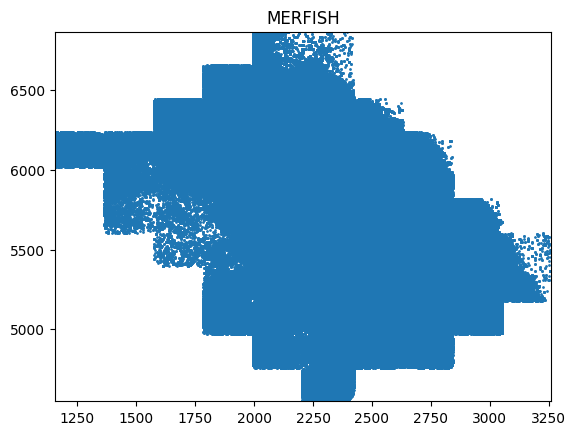

In [10]:
datapath = "data/"
data_name = "MERFISH"
cell_gene_matrix_full = pd.read_csv(datapath + 'cell-gene-matrix.csv')
cell_gene_matrix = cell_gene_matrix_full.iloc[:, 1:-6].transpose()
spatial_data = pd.read_csv(datapath + 'Allen_MERFISH_spots_with_anatomy.csv')
genes = pd.read_csv(datapath + 'MERFISH_genes.csv')

# SEDR Dataset
# data_root = './output/data/10x_Genomics_Visium/'
# adata_h5 = load_visium_sge(sample_id=data_name, save_path=data_root)
# adata_h5.var_names_make_unique()

print(cell_gene_matrix.head())

genes = set(genes['gene'])
# enablePrint()

print('dataset: ', data_name)
print('size:', cell_gene_matrix.shape)
print('number of genes', len(genes))
plot_cell2gene(cell_gene_matrix, data_name)
plot_spatial(spatial_data, data_name)
    
    


# Parameter Setting

In [11]:
sc.settings.figdir = './output/figures/'
sc.settings.writedir = './output/write/'
sc.settings.cachedir = './output/cache/'
sc.settings.datasetdir = './output/data/'

warnings.filterwarnings('ignore')
torch.cuda.cudnn_enabled = False
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('===== Using device: ' + device + " =====")

argsDict = {
    'k': 20,
    'knn_distanceType': 'euclidean',
    'epochs': 200,
    'cell_feat_dim': 200, 
    'feat_hidden1': 100,
    'feat_hidden2': 20,
    'gcn_hidden1': 32,
    'gcn_hidden2': 8,
    'p_drop': 0.2,
    'using_dec': True,
    'using_mask': False,
    'feat_w': 10,
    'gcn_w': 0.1,
    'dec_kl_w': 10,
    'gcn_lr': 0.01,
    'gcn_decay': 0.01,
    'dec_cluster_n': 10,
    'dec_interval': 20,
    'dec_tol': 0.00,
    'eval_resolution': 1,
    'eval_graph_n': 20,
    'device': device,
    'n_clusters': 20
}
params = argparse.Namespace(**argsDict)
params

===== Using device: cpu =====


Namespace(cell_feat_dim=200, dec_cluster_n=10, dec_interval=20, dec_kl_w=10, dec_tol=0.0, device='cpu', epochs=200, eval_graph_n=20, eval_resolution=1, feat_hidden1=100, feat_hidden2=20, feat_w=10, gcn_decay=0.01, gcn_hidden1=32, gcn_hidden2=8, gcn_lr=0.01, gcn_w=0.1, k=20, knn_distanceType='euclidean', n_clusters=20, p_drop=0.2, using_dec=True, using_mask=False)

In [12]:
# Visium Spatial Gene Expression data from 10x Genomics.
# Database: https://support.10xgenomics.com/spatial-gene-expression/datasets
sample_id_list = ['V1_Breast_Cancer_Block_A_Section_1', 'V1_Breast_Cancer_Block_A_Section_2',
'V1_Human_Heart', 'V1_Human_Lymph_Node', 'V1_Mouse_Kidney', 'V1_Adult_Mouse_Brain',
'V1_Mouse_Brain_Sagittal_Posterior', 'V1_Mouse_Brain_Sagittal_Posterior_Section_2',
'V1_Mouse_Brain_Sagittal_Anterior', 'V1_Mouse_Brain_Sagittal_Anterior_Section_2',
'V1_Human_Brain_Section_1', 'V1_Human_Brain_Section_2',
'V1_Adult_Mouse_Brain_Coronal_Section_1',
'V1_Adult_Mouse_Brain_Coronal_Section_2',
'Targeted_Visium_Human_Cerebellum_Neuroscience', 'Parent_Visium_Human_Cerebellum',
'Targeted_Visium_Human_SpinalCord_Neuroscience', 'Parent_Visium_Human_SpinalCord',
'Targeted_Visium_Human_Glioblastoma_Pan_Cancer', 'Parent_Visium_Human_Glioblastoma',
'Targeted_Visium_Human_BreastCancer_Immunology', 'Parent_Visium_Human_BreastCancer',
'Targeted_Visium_Human_OvarianCancer_Pan_Cancer',
'Targeted_Visium_Human_OvarianCancer_Immunology', 'Parent_Visium_Human_OvarianCancer',
'Targeted_Visium_Human_ColorectalCancer_GeneSignature', 'Parent_Visium_Human_ColorectalCancer']

# ################## Data download folder
data_root = './output/data/10x_Genomics_Visium/'
data_name = 'MERFISH_' + str(params.n_clusters) + '_'
save_fold = os.path.join('./output/tangram_dataset/', data_name)

# Load data

In [13]:
### Sample PERCENT% of the data

# PERCENT = 0.001
# NROW = cell_gene_matrix.shape[1]
# IS_PERCENT = False

# spatial_data_pos = np.array(spatial_data[['x_um', 'y_um']])
# n_cells = spatial_data_pos.shape[0]

# if IS_PERCENT:
#     n_row = int(n_cells*PERCENT)
# else:
#     n_row = NROW

# rows_ids = random.sample(range(0, n_cells-1), n_row)
# spatial_selected = spatial_data_pos[rows_ids, :]
# print(spatial_selected.shape)

In [14]:
spatial_selected = np.array(cell_gene_matrix_full[['x_um', 'y_um']])

In [15]:
spatial_data.shape
spatial_selected.shape

(2399, 2)

In [16]:
# ################## Load data
adata = AnnData(np.array(cell_gene_matrix)).transpose()
adata.var_names_make_unique()
adata_X = adata_preprocess(adata, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(spatial_selected, adata.shape[0], params)
params.cell_num = adata.shape[0]
params.save_path = mk_dir(save_fold)
print('==== Graph Construction Finished')

===== Preprocessing Data 
==== Graph Construction Finished


# Model Training

In [17]:
sedr_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()

np.savez(os.path.join(params.save_path, "SEDR_result.npz"), sedr_feat=sedr_feat, deep_Dim=params.feat_hidden2)
print(sedr_feat.shape)

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 10.6021
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 10.6011raining Graph Net with DEC loss:  |#####           | 73 / 200 | Loss: 10.6943

(2399, 28)


# Results

In [18]:
# ################## Result plot
adata_sedr = anndata.AnnData(sedr_feat)
# adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
adata_sedr.obsm['spatial'] = spatial_selected

print(adata_sedr)

sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
sc.tl.umap(adata_sedr)
print(adata_sedr)

AnnData object with n_obs × n_vars = 2399 × 28
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2399 × 28
    uns: 'neighbors', 'umap'
    obsm: 'spatial', 'X_umap'
    obsp: 'distances', 'connectivities'


In [19]:
# print(sedr_feat.shape)
# print(adata_sedr.uns['neighbors'])
cell_gene_matrix_full.iloc[:, -6:]
np.mean(cell_gene_matrix_full["area"])

255.5612463526471

In [20]:
def res_search_fixed_clus(adata, fixed_clus_count, increment=0.02):
    '''
        arg1(adata)[AnnData matrix]
        arg2(fixed_clus_count)[int]
        
        return:
            resolution[int]
    '''
    for res in sorted(list(np.arange(0.2, 2.5, increment)), reverse=True):
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
        if count_unique_leiden == fixed_clus_count:
            break
    return res

In [21]:
eval_resolution = res_search_fixed_clus(adata_sedr, params.n_clusters)
sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

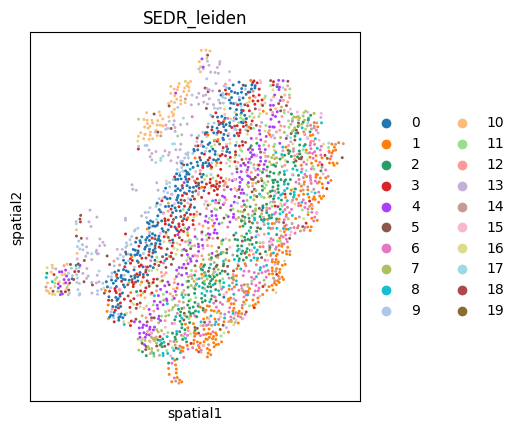

<Figure size 640x480 with 0 Axes>

In [22]:
folder_name = '/'.join(save_fold.split('/')[2:])
sc.pl.spatial(adata_sedr, spot_size=20, color=['SEDR_leiden'], save=folder_name+"_SEDR_leiden_plot")
plt.savefig(os.path.join(params.save_path, "_SEDR_leiden_plot.pdf"), bbox_inches='tight', dpi=150)

df_result = pd.DataFrame(adata_sedr.obs['SEDR_leiden'], columns=['SEDR_leiden'])
df_result.to_csv(os.path.join(params.save_path, "SEDR_leiden_n_result.tsv"),
                 sep='\t', index=False)

## Visualize the train and val split

In [ ]:
# from VGAE.src.utils_func import train_val_split
# adata_h5_train, adata_h5_val = train_val_split(adata_h5, train_frac=0.85)


In [ ]:
# plot_spatial(adata_h5_val)
# plot_cell2gene(adata_h5_val)